# Random Forest Classification

## Set up

First, lets import all the necessary packages :

In [1]:
# Natural Language Toolkit for text processing:
import nltk

#for numerical operations:
import numpy as np

#for data manipulation and analysis:
import pandas as pd

#for plotting
import matplotlib.pyplot as plt

# Scikit-learn:
import sklearn
from sklearnex import patch_sklearn
patch_sklearn(verbose=False)
# Functions for data splitting and grid search/Pipeline and Evaluation:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Text feature extraction:
from sklearn.feature_extraction.text import TfidfVectorizer 

# Random Forest classifier:
from sklearn.ensemble import RandomForestClassifier

# Download NLTK data for text processing:
nltk.download('popular', quiet=True)
nltk.download('universal_tagset', quiet=True)

# Initialize WordNet lemmatizer for text preprocessing:
wnl = nltk.stem.WordNetLemmatizer()

# Define a list of English stopwords for text filtering:
stopwords = nltk.corpus.stopwords.words("english")

Import the training dataset : 

In [2]:
train = pd.read_csv('train.csv')

### Defining text Processing Function

This is the text processing function that we will use as our custom tokenizer to input in the TFIDF Transformer.

In [3]:

def custom_tokenizer(text: str):
    # Replace 'c#' with a placeholder token
    text = text.replace('c#', 'csharpplaceholder')

    text_tokens = nltk.word_tokenize(text)
    output = []

    for w, pos in nltk.pos_tag(text_tokens, tagset="universal"):
        if w.lower() == 'csharpplaceholder':
            # Restore 'c#' as a single token
            output.append('c#')
        else:
            if pos in ["VERB"]:
                pos = "v"
            elif pos in ["ADJ"]:
                pos = "a"
            elif pos in ["ADV"]:
                pos = "r"
            elif pos in ["NOUN"]:
                pos = "n"
            else:
                pos = "n"

            # Lemmatized form accounting for POS-tag
            l = wnl.lemmatize(w, pos=pos)

            # Filter out stopwords
            if l not in stopwords:
                output.append(l)

    return output


## Working on the training data set

First, we will split the data in order to see the accuracy of our model.

In [4]:
from sklearn.ensemble import RandomForestClassifier

x_train, x_test, y_train, y_test = train_test_split(
    train['post'],
    train["tags"],
    random_state=42,
    test_size=0.3
)


### Vectorizing, fitting and transforming with TFIDF

In [5]:
# Initiate the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, lowercase=True, min_df=1e-3, dtype=np.float64)

# Transform the training data
tfidf_train = tfidf_vectorizer.fit_transform(x_train)

# Transform the test data
tfidf_test = tfidf_vectorizer.transform(x_test)


/Users/evabattolla/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### GridSearch

We define our grid of parameter with reasonable values to be compared and then initate our Random Forest Classifier with a random_state = 42 for reproducability reasons.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [300, 500, 600],
    'max_depth': [None, 5, 10],
    'min_samples_split': [5, 10, 20],
}

# Create the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the Grid Search on the training data
grid_search.fit(tfidf_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 500}


The grid search has found the best parameters. 

We can now predict with the .predict method, which uses the best parameters. We will also print the classification report to inspect how our model is performing on the different classes.

In [17]:
y_test_pred_best_rf = grid_search.predict(tfidf_test)

# Print accuracy and classification report for the best model
print("\nAccuracy of the Random Forest Model:", accuracy_score(y_test, y_test_pred_best_rf))
print("\nClassification Report for the Random Forest Model:\n", classification_report(y_test, y_test_pred_best_rf))


Accuracy of the Random Forest Model: 0.8121428571428572

Classification Report for the Random Forest Model:
                precision    recall  f1-score   support

         .net       0.66      0.68      0.67       409
      android       0.95      0.85      0.90       432
    angularjs       0.98      0.93      0.95       431
      asp.net       0.82      0.69      0.75       456
            c       0.85      0.90      0.87       431
           c#       0.69      0.76      0.72       436
          c++       0.93      0.81      0.87       429
          css       0.78      0.88      0.83       425
         html       0.73      0.72      0.72       418
          ios       0.69      0.66      0.68       414
       iphone       0.60      0.61      0.60       393
         java       0.89      0.80      0.84       435
   javascript       0.84      0.81      0.83       410
       jquery       0.87      0.94      0.90       400
        mysql       0.87      0.79      0.83       436
  objecti

Plotting a confusion Matrix allows us to visualize our result.

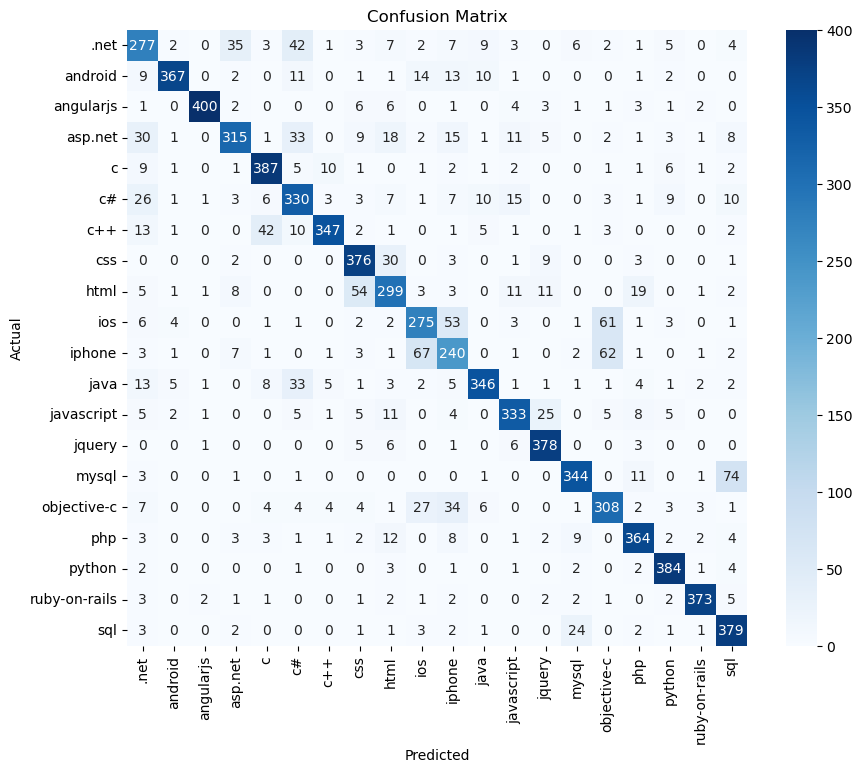

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
tags_unique = sorted(pd.unique(train["tags"]).tolist())

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=tags_unique, yticklabels=tags_unique)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Fitting model on training data for prediction on test data

Import the test data set.

In [18]:
data_test =pd.read_csv('test.csv')

We transform both the training and the test data set.

In [26]:
# Transform the training data
tfidf_train = tfidf_vectorizer.fit_transform(train['post'])

# Transform the test data
tfidf_test = tfidf_vectorizer.transform(data_test['post'])


We initiate the Random Forest Classifier with values found with the GRid Search on the train-test split
and then predict the tags for the test dataset with the missing tags.

In [ ]:
rf = RandomForestClassifier(n_estimators = 500, max_depth = None, min_samples_split = 10, random_state = 42)

# Fit the RF model
rf.fit(tfidf_train, train['tags'])

# Predictions
tags_pred = rf.predict(tfidf_test)

Create a new file for the solutions.

In [22]:
solution = data_test.copy() # use .copy() in order not to modify the original data_set object
solution.insert(2,"tags", tags_pred) # add predictions to file
solution=solution.drop('post', axis=1) # drop 'post' column to keep only two columns ('Id' and 'tags')

Ensure that the solutions have the right format :

In [35]:
print(solution.shape)


(12000, 2)


In [36]:
print(solution.head())

   Id       tags
0   2    asp.net
1  12        ios
2  13    asp.net
3  19     iphone
4  22  angularjs


Save the solution in a CSV file for Kaggle submission:

In [23]:
solution.to_csv('Sol_RF_tokenized7.csv', index= False) # Save file in working directory